<a href="https://colab.research.google.com/github/JustynaMatewka/_Flower_Match_/blob/test_FCC/fcc_BIKES_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [ ]:
dataset_cols = ["bike_count","hour","temp","humidity","wind","visibility","dew_point_temp","radiation","rain","snow","functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [ ]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_point_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


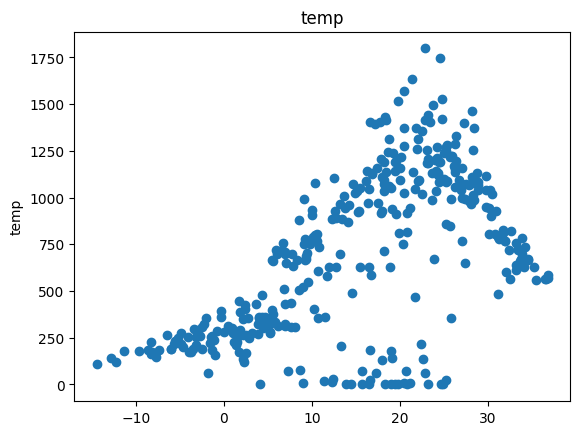

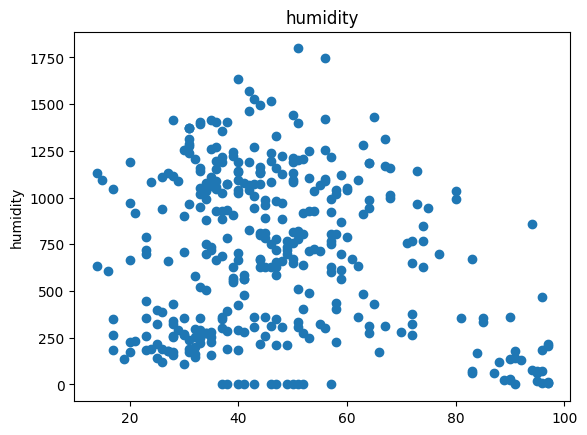

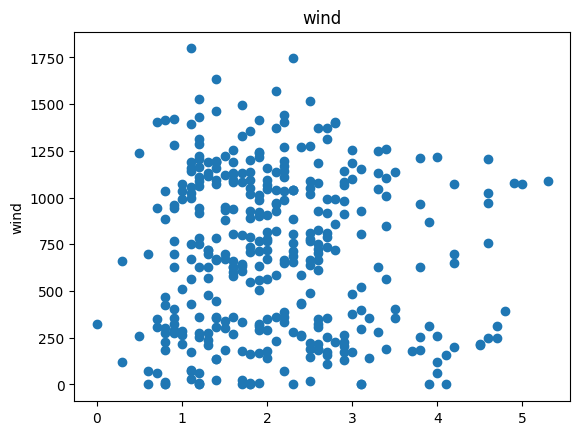

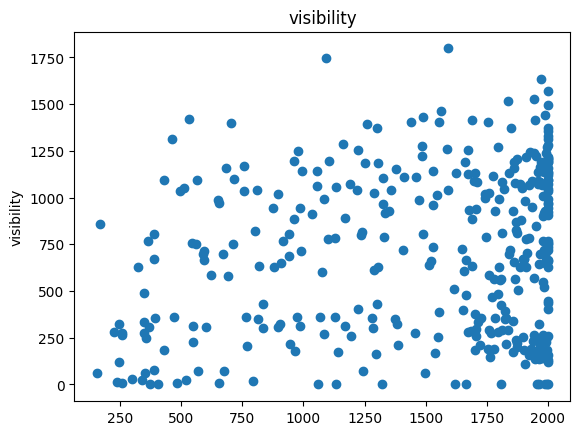

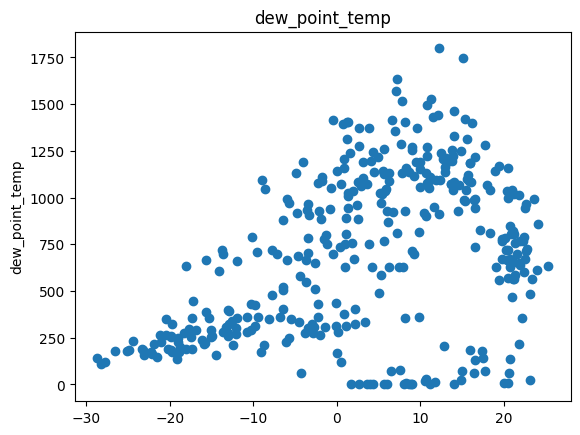

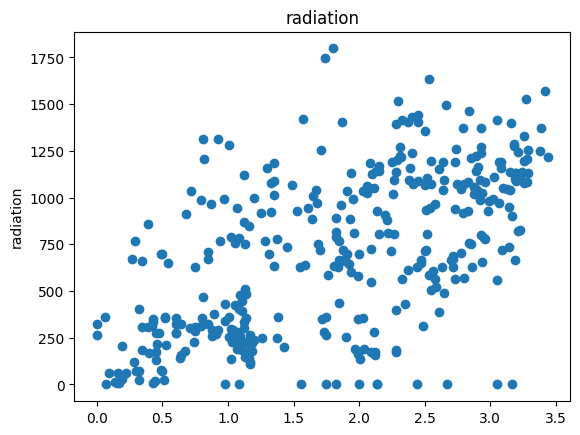

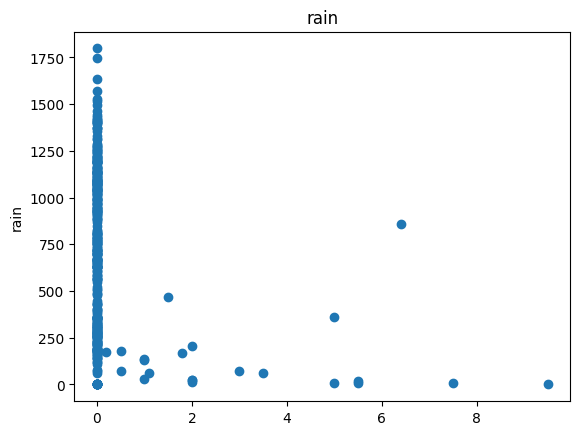

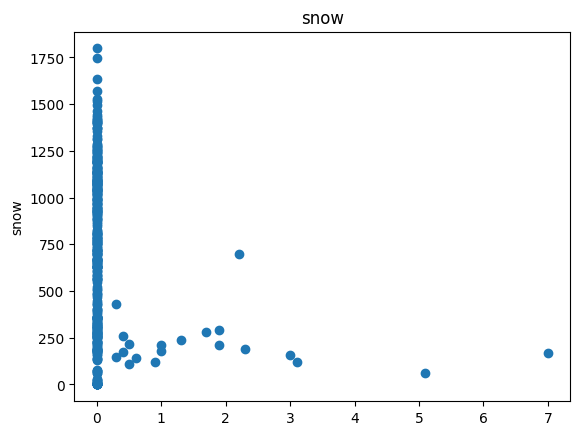

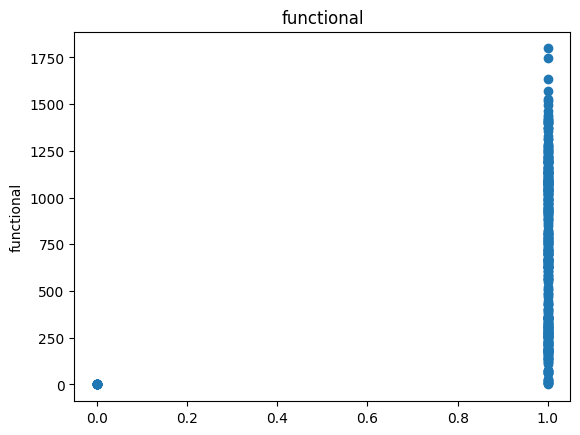

In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.ylabel(label)
  plt.show()

Patrząc po tych wykresach widać, że "wind", "visibility", "functional" zdecydowanie nie są liniowe, usuwamy je, żeby nie psuły uczenia modelu

In [ ]:
df = df.drop(['wind', "visibility", "functional"], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,dew_point_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


Podział danych na część treningową, walidacyjną i testową

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [ ]:
print(temp_reg.coef_, temp_reg.intercept_)

temp_reg.score(X_test_temp, y_test_temp)  #Dało słaby wynik

[[20.90575935]] [379.18665451]


0.40179771150604504

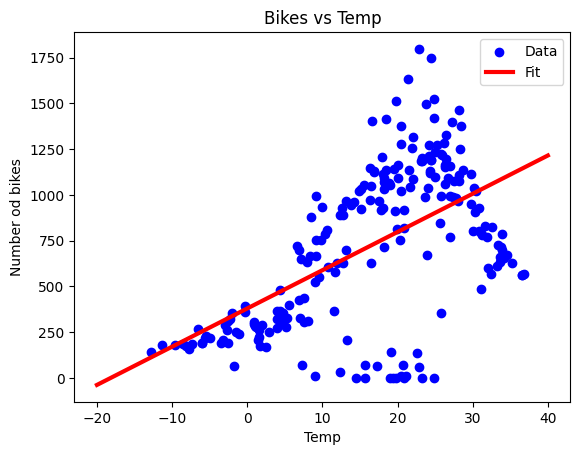

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number od bikes")
plt.xlabel("Temp")
plt.show()

Multiple Linear Regression

In [ ]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_point_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [ ]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1::])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1::])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1::])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [ ]:
all_reg.score(X_test_all, y_test_all)

0.4953891750909051

Regression with Neural Net

In [102]:
def plot_history(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)

    plt.show()

In [96]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [97]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [98]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [99]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

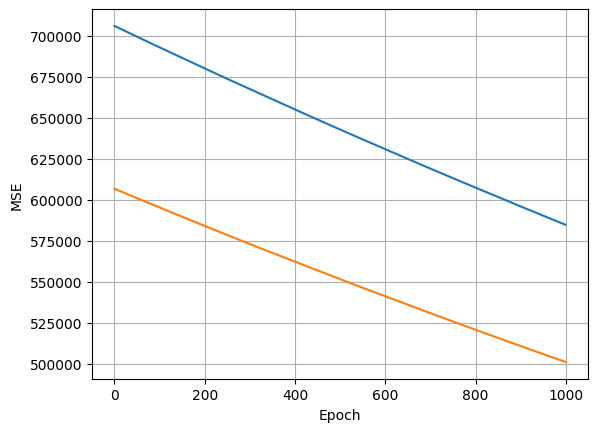

In [103]:
plot_history(history)

4/4 [==============================] - 0s 3ms/step


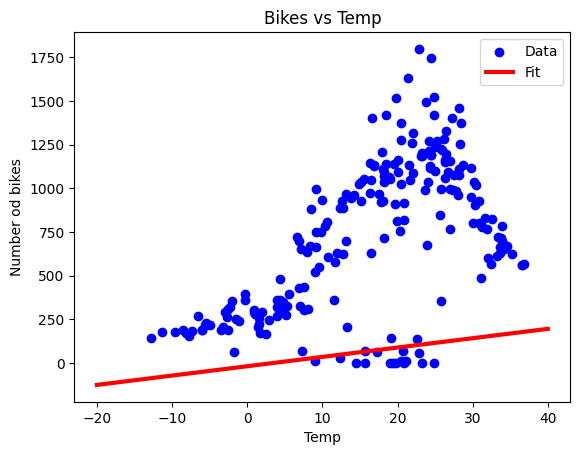

In [104]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number od bikes")
plt.xlabel("Temp")
plt.show()

In [ ]:
#  3:00:00